In [ ]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [ ]:
import tensorflow as tf

import os
import time
import numpy as np

from matplotlib import pyplot as plt
from IPython import display

In [ ]:
import pickle

In [ ]:
with open('/content/gdrive/My Drive/water_mark/list_of_files.pkl','rb') as f:
  files = pickle.load(f)

In [ ]:
len(files)

48865

In [ ]:
input_img = []
output_img = []
for i in files:
  input_img.append('/content/gdrive/My Drive/water_mark/annotation/annotation/'+str(i))
  output_img.append('/content/gdrive/My Drive/water_mark/images/images/'+str(i))

In [ ]:
len(input_img)

48865

In [ ]:
3054 * 16

48864

In [ ]:
test_samples = np.random.choice(files,25)

In [ ]:
test_samples

array(['dog.244.jpg', 'cat.9413.jpg', '1117690.jpg', 'dog.10499.jpg',
       'cat.8914.jpg', '2819203.jpg', '231249.jpg', 'cat.6582.jpg',
       '3448662.jpg', 'dog.4349.jpg', '2345176.jpg', '732507.jpg',
       '2_682.jpg', '449369.jpg', '5_988.jpg', 'cat.1114.jpg',
       'dog.8718.jpg', 'cat.2271.jpg', '1265464.jpg', '773487.jpg',
       'cat.11042.jpg', '2_595.jpg', 'dog.11351.jpg', '453850.jpg',
       'cat.8705.jpg'], dtype='<U13')

In [ ]:
def load(inp_img,out_img):
  input_image = tf.io.read_file(inp_img)
  input_image = tf.image.decode_jpeg(input_image)

  output_image = tf.io.read_file(out_img)
  output_image = tf.image.decode_jpeg(output_image)
 

  input_image = tf.cast(input_image, tf.float32)
  output_image = tf.cast(output_image, tf.float32)

  return input_image, output_image

In [ ]:
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

In [ ]:
def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image[0], cropped_image[1]

In [ ]:
def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

In [ ]:
@tf.function()
def random_jitter(input_image, real_image):
  # resizing to 286 x 286 x 3
  input_image, real_image = resize(input_image, real_image, 286, 286)

  # randomly cropping to 256 x 256 x 3
  input_image, real_image = random_crop(input_image, real_image)

  if tf.random.uniform(()) > 0.5:
    # random mirroring
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

In [ ]:
def load_image_train(input_image,real_image):
  input_image, real_image = load(input_image,real_image)
  input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [ ]:
def load_image_test(input_image,real_image):
  input_image, real_image = load(input_image,real_image)
  input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((input_img,output_img))

In [ ]:
for i in train_dataset.take(10):
  print(i)

(<tf.Tensor: shape=(), dtype=string, numpy=b'/content/gdrive/My Drive/water_mark/images/images/0_0.jpg'>, <tf.Tensor: shape=(), dtype=string, numpy=b'/content/gdrive/My Drive/water_mark/annotation/annotation/0_0.jpg'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'/content/gdrive/My Drive/water_mark/images/images/0_1.jpg'>, <tf.Tensor: shape=(), dtype=string, numpy=b'/content/gdrive/My Drive/water_mark/annotation/annotation/0_1.jpg'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'/content/gdrive/My Drive/water_mark/images/images/0_10.jpg'>, <tf.Tensor: shape=(), dtype=string, numpy=b'/content/gdrive/My Drive/water_mark/annotation/annotation/0_10.jpg'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'/content/gdrive/My Drive/water_mark/images/images/0_100.jpg'>, <tf.Tensor: shape=(), dtype=string, numpy=b'/content/gdrive/My Drive/water_mark/annotation/annotation/0_100.jpg'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'/content/gdrive/My Drive/water_mark/images/images/0_101.jpg'>, <tf.Tensor

In [ ]:
train_dataset = train_dataset.map(load,
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [ ]:
for i in train_dataset.take(10):
  print(i)

In [ ]:
BUFFER_SIZE = 400
BATCH_SIZE = 16
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((input_img,output_img))
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [ ]:
test_input_img = []
test_output_img = []
for i in test_samples:
  test_input_img.append('/content/gdrive/My Drive/water_mark/annotation/annotation/'+str(i))
  test_output_img.append('/content/gdrive/My Drive/water_mark/images/images/'+str(i))

In [ ]:
test_dataset = tf.data.Dataset.from_tensor_slices((test_input_img,test_output_img))
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(5)

In [ ]:
OUTPUT_CHANNELS = 3


In [ ]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [ ]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [ ]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[256,256,3])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False), # (bs, 128, 128, 64)
    downsample(128, 4), # (bs, 64, 64, 128)
    downsample(256, 4), # (bs, 32, 32, 256)
    downsample(512, 4), # (bs, 16, 16, 512)
    downsample(512, 4), # (bs, 8, 8, 512)
    downsample(512, 4), # (bs, 4, 4, 512)
    downsample(512, 4), # (bs, 2, 2, 512)
    downsample(512, 4), # (bs, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
    upsample(512, 4), # (bs, 16, 16, 1024)
    upsample(256, 4), # (bs, 32, 32, 512)
    upsample(128, 4), # (bs, 64, 64, 256)
    upsample(64, 4), # (bs, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh') # (bs, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [ ]:
generator = Generator()

In [ ]:
LAMBDA = 100

In [ ]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

In [ ]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar]) # (bs, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
  down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
  down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

In [ ]:
discriminator = Discriminator()

In [ ]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
checkpoint_path = "/content/gdrive/My Drive/water_mark/train"
checkpoint_prefix = os.path.join(checkpoint_path, "ckpt")
ckpt = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=3)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

Latest checkpoint restored!!


In [ ]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15,15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [ ]:
EPOCHS = 150

In [ ]:
@tf.function
def train_step(input_image, target, epoch):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

In [ ]:
def fit(train_ds, epochs, test_ds):
  for epoch in range(epochs):
    start = time.time()

    display.clear_output(wait=True)

    for example_input, example_target in test_ds.take(1):
      generate_images(generator, example_input, example_target)
    print("Epoch: ", epoch)

    # Train
    for n, (input_image, target) in train_ds.enumerate():
      print('.', end='')
      if (n+1) % 100 == 0:
        print()
      train_step(input_image, target, epoch)
    print()

    # saving (checkpoint) the model every 20 epochs
    if (epoch + 1) % 20 == 0:
      ckpt_save_path = ckpt_manager.save()
      print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))
    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                        time.time()-start))
    ckpt_manager.save()

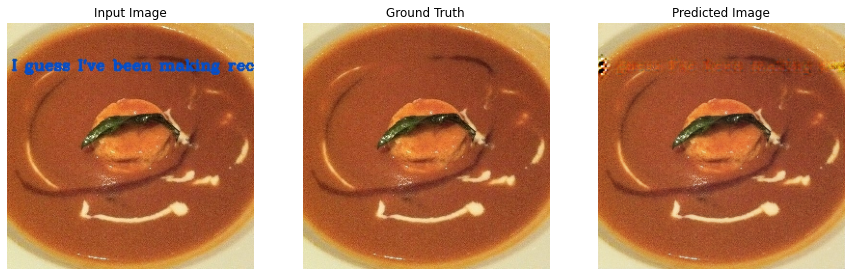

Epoch:  14
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
................................................................................

In [ ]:
fit(train_dataset, EPOCHS, test_dataset)
